# Model Selection

## Packages

We begin by loading in necessary software packages, introducing options for saving the results, and software for computing PSIS LOO in Python.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#%matplotlib notebook

import netCDF4 as nc4
import numpy as np
import pandas as pd
import logging
from __future__ import division # For Python 2 compatibility

In [ ]:
# use test data (not all data is used for fitting/training)
use_testdata = False

# create plots of the data
show_data = True

# netCDF output file (set to None to not save output)
savename_output = 'mcmc_log_lik-refit_update.nc'

# save the Stan output instead a few stats (only active if filename is specified above)
save_stan_output = True

# specify the Stan variable names to save; if set to None, all variables are saved 
# (only active if save_stan_output is True)
varnames_save = None

# the number of tries to fit each Stan model to achieve an R-hat < 1.1
num_tries = 3

# the number of chains to run
num_chains = 6

# the prior_only option passed to each Stan model
prior_only = False

In [1]:
"""Pareto smoothed importance sampling (PSIS)
This module implements Pareto smoothed importance sampling (PSIS) and PSIS
leave-one-out (LOO) cross-validation for Python (Numpy).
Included functions
------------------
psisloo
    Pareto smoothed importance sampling leave-one-out log predictive densities.
psislw
    Pareto smoothed importance sampling.
gpdfitnew
    Estimate the paramaters for the Generalized Pareto Distribution (GPD).
gpinv
    Inverse Generalised Pareto distribution function.
sumlogs
    Sum of vector where numbers are represented by their logarithms.
References
----------
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Practical
Bayesian model evaluation using leave-one-out cross-validation
and WAIC. Statistics and Computing, 27(5):1413–1432.
doi:10.1007/s11222-016-9696-4. https://arxiv.org/abs/1507.04544
Aki Vehtari, Andrew Gelman and Jonah Gabry (2017). Pareto
smoothed importance sampling. https://arxiv.org/abs/arXiv:1507.02646v5
"""

# 3-Clause BSD License
"""
Copyright 2017 Aki Vehtari, Tuomas Sivula
Redistribution and use in source and binary forms, with or without modification,
are permitted provided that the following conditions are met:
1. Redistributions of source code must retain the above copyright notice, this
list of conditions and the following disclaimer.
2. Redistributions in binary form must reproduce the above copyright notice,
this list of conditions and the following disclaimer in the documentation and/or
other materials provided with the distribution.
3. Neither the name of the copyright holder nor the names of its contributors
may be used to endorse or promote products derived from this software without
specific prior written permission.
THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED
WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR
ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES
(INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON
ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT
(INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS
SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. """


def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.
    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).
    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).
    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.
    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities
    loos : ndarray
        individual leave-one-out log predictive density terms
    ks : ndarray
        estimated Pareto tail indeces
    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out

## Load, Plot Data

In [3]:
# load data
datafiles = {
    #'seaflow':'data/SeaFlow_PSD_hourlyCOUNT_v3_regrid-25-8_day2.nc',
    #'zinser':'data/Zinser_SizeDist_calibrated-26-6.nc',
    'zinser':'data/Zinser_SizeDist_logtransform-25-7.nc',
}

itestfiles = {
    'seaflow':'data/Zinser_SizeDist_calibrated-26-6-itest.csv', # same as zinser
    'zinser':'data/Zinser_SizeDist_calibrated-26-6-itest.csv',         
}

desc = {
    'seaflow':'SeaFlow dataset',
    'zinser':'Zinser dataset',    
}

size_units = 'fg C cell$^{-1}$'

data_gridded = {}
for dataname in datafiles:
    data_gridded[dataname] = {}
    with nc4.Dataset(datafiles[dataname]) as nc:
        for var in nc.variables:
            data_gridded[dataname][var] = nc.variables[var][:]

    # create "counts" entry
    if 'count' in data_gridded[dataname]:
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    elif 'abundance' in data_gridded[dataname]:
        logging.warning('{}: Using "abundance" data to generate count data for the model.'.format(dataname))
        data_gridded[dataname]['counts'] = (data_gridded[dataname]['count'][None,:] * data_gridded[dataname]['w_obs']).astype(int)
    else:
        raise RuntimeError('Cannot find a "count" or "abundance" entry in "{}".'.format(datafiles[dataname]))
        
    
    # add description
    desc[dataname] += ' (m={data[m]}, $\Delta_v^{{-1}}$={data[delta_v_inv]})'.format(data=data_gridded[dataname])

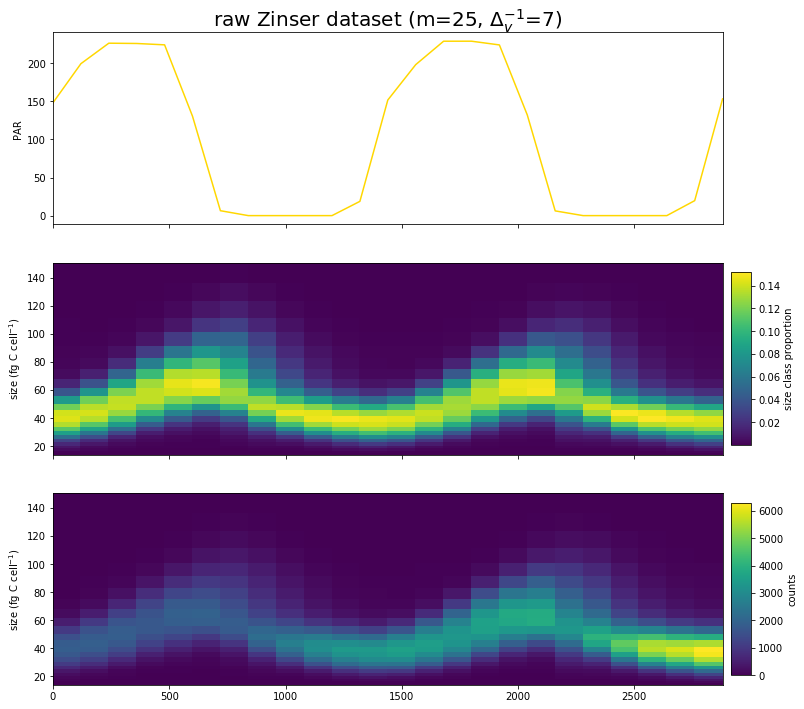

In [4]:
def add_colorbar(ax, **cbarargs):
    axins_cbar = inset_axes(ax, width='3%', height='90%', loc=5, bbox_to_anchor=(0.05,0.0,1,1), bbox_transform=ax.transAxes)
    mpl.colorbar.ColorbarBase(axins_cbar, orientation='vertical', **cbarargs)

if show_data:
    for i,dataname in enumerate(data_gridded):
        nrows = 3

        v_min = data_gridded[dataname]['v_min']
        delta_v = 1.0/data_gridded[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data_gridded[dataname]['m'])*delta_v) 

        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('raw '+desc[dataname], size=20)
        ax.plot(data_gridded[dataname]['time'], data_gridded[dataname]['PAR'], color='gold')
        ax.set(ylabel='PAR')

        ax = axs[1]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['w_obs'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')

        ax = axs[2]
        pc = ax.pcolormesh(data_gridded[dataname]['time'], v, data_gridded[dataname]['counts'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
    axs[-1].set_xlabel=('time (minutes)')
None

## Process and Re-plot Data

In [5]:
# prepare data for Stan model

seaflow_filter_par = False

if 'data' not in globals():
    data = {}

for dataname in data_gridded:
    dt = 20 # in units of minutes
    
    data[dataname] = {'dt':dt}
    for v in ('m','v_min','delta_v_inv'):
        data[dataname][v] = data_gridded[dataname][v]

    if 'seaflow' in dataname:
        limit_days = None
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        if limit_days is None:
            limit_days = int(np.ceil(data[dataname]['t_obs'][-1]/1440))
        
        if seaflow_filter_par:
            # median filter PAR
            # see: medianfilter_par.ipynb
            n = len(data_gridded[dataname]['PAR'])
            wsh = 30 # half of median filter window size; window size is 2*wsh+1
            par = np.array([np.median(data_gridded[dataname]['PAR'][max(0,i-wsh):min(n,i+wsh+1)]) for i in range(n)])
        else:
            par = data_gridded[dataname]['PAR']
    else:
        limit_days = 2
        
        data[dataname]['obs'] = data_gridded[dataname]['w_obs']
        data[dataname]['t_obs'] = data_gridded[dataname]['time']
        par = data_gridded[dataname]['PAR']
        
    if limit_days > 0:
        limit_minutes = limit_days*1440
        
        ind_obs = data[dataname]['t_obs'] < limit_minutes
        
        if not np.all(ind_obs):
            print('{}: limit_days is set to {}, removing {}/{} observation times'.format(dataname, limit_days, ind_obs.size-np.count_nonzero(ind_obs), ind_obs.size))
        
        data[dataname]['t_obs'] = data[dataname]['t_obs'][ind_obs]
        data[dataname]['obs'] = data[dataname]['obs'][:,ind_obs]
        
        data[dataname]['nt'] = int(limit_minutes//data[dataname]['dt'])

    data[dataname]['nt_obs'] = data[dataname]['t_obs'].size
    
    if use_testdata:
        # load cross-validation testing indices and add them to data
        data[dataname]['i_test'] = np.loadtxt(itestfiles[dataname]).astype(int)
        # remove last index, so that dimensions agree
        data[dataname]['i_test'] = data[dataname]['i_test'][:-1]
    else:
        # set all indices to zero
        data[dataname]['i_test'] = np.zeros(data[dataname]['nt_obs'], dtype=int)
        
    # switch on or off data fitting
    data[dataname]['prior_only'] = int(prior_only)
    
    # add light data
    t = np.arange(data[dataname]['nt'])*data[dataname]['dt']
    data[dataname]['E'] = np.interp(t, xp=data_gridded[dataname]['time'], fp=par)
    
    # real count data
    data[dataname]['obs_count'] = data_gridded[dataname]['counts'][:, ind_obs]
    
    # consistency check
    if len(data[dataname]['i_test']) != data[dataname]['nt_obs']:
        raise ValueError('Invalid number of testing indices for "{}" (expected {}, got {}).'.format(dataname,data[dataname]['nt_obs'],len(data[dataname]['i_test'])))

zinser: limit_days is set to 2, removing 1/25 observation times


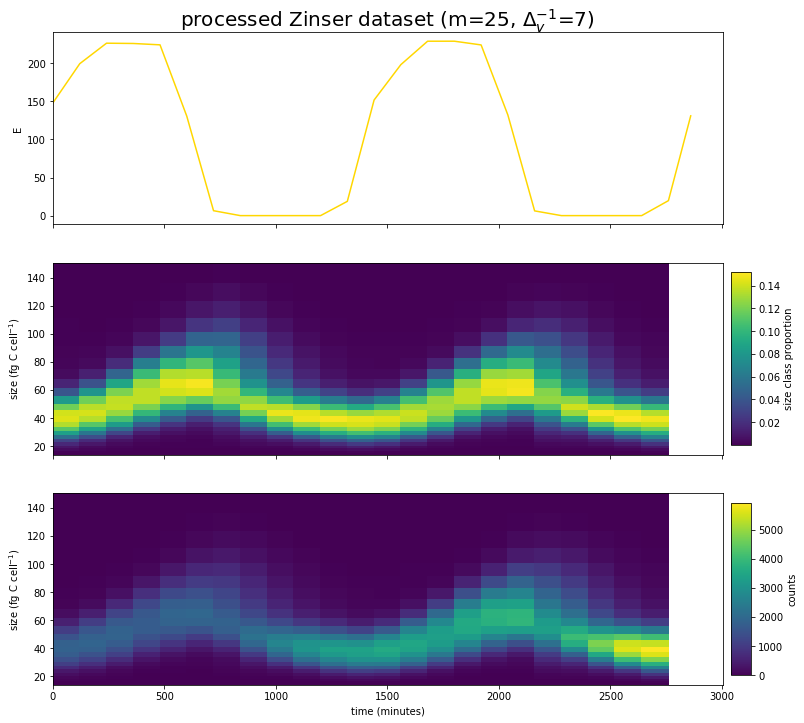

In [6]:
if show_data:
    for i,dataname in enumerate(data):
        nrows = 3

        v_min = data[dataname]['v_min']
        delta_v = 1.0/data[dataname]['delta_v_inv']
        v = v_min * 2**(np.arange(data[dataname]['m'])*delta_v) 
        t = np.arange(data[dataname]['nt'])*data[dataname]['dt']


        fig,axs = plt.subplots(nrows=nrows, sharex=True, figsize=(12,4*nrows))

        ax = axs[0]
        ax.set_title('processed '+desc[dataname], size=20)
        ax.plot(t, data[dataname]['E'], color='gold')
        ax.set(ylabel='E')

        ax = axs[1]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='size class proportion')
        ax.set_xlim(left=0.0)

        ax = axs[2]
        pc = ax.pcolormesh(data[dataname]['t_obs'], v, data[dataname]['obs_count'], shading='auto')
        ax.set(ylabel='size ({})'.format(size_units))
        #ax.text(0.01, 0.95, desc[dataname], color='white', size=16, transform=ax.transAxes, ha='left', va='top')
        add_colorbar(ax, norm=pc.norm, cmap=pc.cmap, label='counts')
        ax.set_xlim(left=0.0)
    axs[-1].set_xlabel('time (minutes)')
None

## Choose models to fit

In [7]:
desc_model = {
    'm1':'m1',
    'm2':'m2',
#     'm3':'m3',
    'm4':'m4',
    'm5':'m5',
#     'm6':'m6',
#     'm7':'m7',
# #     'm8':'m8',
#     'm9':'m9',
#     'm10':'m10',
#     'm11':'m11',
#     'm12':'m12',
#     'm13':'m13',
#     'm14':'m14',
    'm3u':'m3u',
    'm6u':'m6u',
    'm7u':'m7u',
#     'm8u':'m8u',
#     'm9u':'m9u',
    'm11u':'m11u',
    'm12u':'m12u',
#     'm13u':'m13u',
#     'm14u':'m14u',
}
# preparing for some regular expression magic
model_code_replacements = {
    'm1':(),
    'm2':(),
#     'm3':(),
    'm4':(),
    'm5':(),
#     'm6':(),
#     'm7':(),
#     'm8':(),
#     'm9':(),
#     'm10':(),
#     'm11':(),
#     'm12':(),
#     'm13':(),
#     'm14':(),
    'm3u':(),
    'm6u':(),
    'm7u':(),
#     'm8u':(),
#     'm9u':(),
    'm11u':(),
    'm12u':(),
#     'm13u':(),
#     'm14u':(),
}
model_stan_key = {
    'm1':'c1',
    'm2':'c2',
#     'm3':'c3',
    'm4':'c4',
    'm5':'c5',
#     'm6':'c6',
#     'm7':'c7',
#     'm8':'c8',
#     'm9':'c9',
#     'm10':'c10',
#     'm11':'c11',
#     'm12':'c12',
#     'm13':'c13',
#     'm14':'c14',
    'm3u':'c3u',
    'm6u':'c6u',
    'm7u':'c7u',
#     'm8u':'c8u',
#     'm9u':'c9u',
    'm11u':'c11u',
    'm12u':'c12u',
#     'm13u':'c13u',
#     'm14u':'c14u',
}
stan_files = {
    'c1':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_freedelta_normparam_trackgrowthvol_xval2.stan',
    'c2':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_normparam_trackgrowthvol_xval2.stan',
#     'c3':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv6_normparam_trackgrowthvol_xval2.stan',
    'c4':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv1_normparam_trackgrowthvol_xval2.stan',
    'c5':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respv2_normparam_trackgrowthvol_xval2.stan',
#     'c6':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv6_normparam_trackgrowthvol_xval2.stan',
#     'c7':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv7_normparam_trackgrowthvol_xval2.stan',
#     'c8':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv6_normparam_trackgrowthvol_xval2.stan',
#     'c9':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv7_normparam_trackgrowthvol_xval2.stan',
#     'c10':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respv2_normparam_trackgrowthvol_xval2.stan',
#     'c11':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
#     'c12':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
#     'c13':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv6_normparam_trackgrowthvol_xval2.stan',
#     'c14':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv7_normparam_trackgrowthvol_xval2.stan',
    'c3u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c6u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv8_normparam_trackgrowthvol_xval2.stan',
    'c7u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_respiv9_normparam_trackgrowthvol_xval2.stan',
#     'c8u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv8_normparam_trackgrowthvol_xval2.stan',
#     'c9u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_respiv9_normparam_trackgrowthvol_xval2.stan',
    'c11u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
    'c12u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
#     'c13u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv8_normparam_trackgrowthvol_xval2.stan',
#     'c14u':'stancode_gallery3/matrixmodel_mlmultinom_estinilnorm2_monodelta2-lightsig_resp_gammaiv9_normparam_trackgrowthvol_xval2.stan',
}

## Fit Models to the Data

In [8]:
import pystan
import re
import time

def get_max_rhat(fit):
    s = fit.summary()
    irhat = s['summary_colnames'].index("Rhat")
    return np.nanmax(s['summary'][:,irhat])

if 'models' not in globals():
    models = {}
if 'mcmcs' not in globals():
    mcmcs = {}
if 'maxrhats' not in globals():
    maxrhats = {}
if 'sampling_time' not in globals():
    sampling_time = {}
if 'num_tries' not in globals():
    num_tries = 3
    
try_again = True
refit_all = False

refit_required = {}
stan_base_code = {}
for key,stan_file in stan_files.items():
    with open(stan_file) as f:
        stan_base_code[key] = f.read()

stan_code = {}
for model in desc_model:
    code_split = stan_base_code[model_stan_key[model]].split('\n')
    code_split_new = []
    for line in code_split:
        line_new = line
        for replacement in model_code_replacements[model]:
            m = re.match(replacement[0],line_new)
            if m:
                line_new = m.groups(0)[0]+replacement[1]
                print('{}: patching in "{}"'.format(model, line_new))
        code_split_new.append(line_new)
                
    stan_code[model] = '\n'.join(code_split_new)

for model in desc_model:
    refit_required[model] = True
    if model in models and models[model].model_code == stan_code[model]:
        print('{}: unchanged code, not recompiling'.format(model))
        refit_required[model] = False
    else:
        if model in models:
            print('{}: code change detected, recompiling'.format(model))
        else:
            print('{}: compiling'.format(model))
        models[model] = pystan.StanModel(model_code=stan_code[model], model_name=model, obfuscate_model_name=False)

# run a bunch of experiments -- this may take a while
for model in models:
    if model not in maxrhats:
        maxrhats[model] = {}
    if model not in sampling_time:
        sampling_time[model] = {}
    for dataname in data:
        if dataname not in maxrhats[model]:
            maxrhats[model][dataname] = []
        if dataname not in sampling_time[model]:
            sampling_time[model][dataname] = []
        if model in mcmcs:
            if dataname in mcmcs[model] and not refit_all and not refit_required[model]:
                print('{}: found existing results:'.format(model))
                print('{} ({})'.format(model, desc_model[model])) 
                print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x))
                rhat_max = get_max_rhat(mcmcs[model][dataname])
                if try_again and rhat_max >= 1.1:
                    print('{}: found Rhat={:.3f}, trying again'.format(model,rhat_max))
                else:
                    print('{}: not re-running model'.format(model))
                    print()
                    continue
            elif refit_all:
                print('{}: refit_all is active, re-running model'.format(model))
            elif refit_required[model]:
                print('{}: change in model code requires re-running model'.format(model))
        else:
            mcmcs[model] = {}
        for itry in range(num_tries):
            t0 = time.time()
            mcmcs[model][dataname] = models[model].sampling(data=data[dataname], iter=2000, chains=num_chains)
            sampling_time[model][dataname].append(time.time() - t0) # in seconds
            # get max Rhat
            rhat_max = get_max_rhat(mcmcs[model][dataname])
            maxrhats[model][dataname].append(rhat_max)
            print('{}: in try {}/{} found Rhat={:.3f}'.format(model, itry+1, num_tries, rhat_max), end='')
            if rhat_max < 1.1 or itry == num_tries - 1:
                print()
                break
            print(', trying again')
        
        print('{} ({})'.format(model, desc_model[model])) 
        print('\n'.join(x for x in mcmcs[model][dataname].__str__().split('\n') if '[' not in x))
        print()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m1 NOW.


m1: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m2 NOW.


m2: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m4 NOW.


m4: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m5 NOW.


m5: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m3u NOW.


m3u: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m6u NOW.


m6u: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m7u NOW.


m7u: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m11u NOW.


m11u: compiling


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m12u NOW.


m12u: compiling


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m1: in try 1/3 found Rhat=1.265, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m1: in try 2/3 found Rhat=15.917, trying again


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m1: in try 3/3 found Rhat=15.901
m1 (m1)
Inference for Stan model: m1.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_mu                3.09    0.14   0.98   1.31   2.38   3.02   3.75   5.12     48   1.07
delta_sigma             2.15    1.92   3.42   0.08   0.33   0.69   1.37  11.41      3   4.25
gamma_max               4.79    0.56   2.12   0.38   3.12   5.25   6.73   7.43     14   1.14
rho_max                 3.74    0.05   2.08   0.27   2.02   3.69   5.51   7.23   1457   1.01
E_star                1054.5  139.05  756.5  92.55 484.37 825.44 1528.7 2856.5     30   1.07
sigma                  26.99    34.8  60.42 1.0e-3   0.01   0.03   0.07 171.63      3   15.9
divrate                 0.96  8.7e-3   0.35   0.52   0.73   0.91   1.08   1.97   1648   1.01
lp__                  -1.4e6  116.43 203.04 -1.4e6 -1.4e6 -1.4e6 -1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m2: in try 1/3 found Rhat=1.001
m2 (m2)
Inference for Stan model: m2.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              40.26     0.2   9.65  25.49  33.14   38.8  46.05   63.5   2280    1.0
gamma_max               6.88  8.5e-3   0.53   5.51    6.6   7.02    7.3   7.48   3958    1.0
rho_max                 3.68    0.02   2.15    0.2   1.81   3.63   5.52   7.28  11342    1.0
E_star                478.39     0.8  53.52 354.92 447.38 485.09 515.47 567.96   4447    1.0
sigma                 163.53     0.1   9.59  144.9 157.04  163.3 169.93 182.58  10157    1.0
divrate                 1.07  6.1e-4   0.05   0.98   1.04   1.07   1.11   1.17   6411    1.0
lp__                  -1.4e6    0.39  18.35 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2234    1.0

Samples were drawn using NUTS at Thu Nov 12 13:21:22 2020.
For each

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m4: in try 1/3 found Rhat=1.005
m4 (m4)
Inference for Stan model: m4.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               59.5     0.1   7.76  43.37  53.97  60.23   66.0  71.32   6032    1.0
gamma_max               7.01    0.01   0.42   5.92    6.8   7.13   7.33   7.48   1583    1.0
rho_max                 0.79  4.3e-4   0.03   0.73   0.77   0.79   0.81   0.85   5197    1.0
E_star                325.61    0.72  29.79  252.6 309.59 330.87 346.61  370.9   1702    1.0
sigma                  304.1     0.2  17.57 270.63 292.08 303.72 315.73 339.95   7959    1.0
divrate                 0.68  3.2e-4   0.03   0.63   0.66   0.68    0.7   0.73   6218    1.0
lp__                  -1.4e6    0.37  18.25 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2446    1.0

Samples were drawn using NUTS at Thu Nov 12 13:43:22 2020.
For each

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m5: in try 1/3 found Rhat=1.005
m5 (m5)
Inference for Stan model: m5.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               38.4    0.25   9.99   23.9  31.02  36.59  43.91   62.5   1574    1.0
gamma_max               4.76    0.02   1.05   3.36   3.91   4.53   5.45   7.13   2210    1.0
rho_max                 1.01  6.0e-4   0.04   0.95   0.99   1.01   1.04   1.09   3489    1.0
E_star                218.98    1.74  81.89 104.62 152.66 202.73 274.77 397.54   2221    1.0
sigma                 467.25    0.33  25.83 418.11 449.63 466.67 484.34 517.55   6264    1.0
divrate                 0.46  2.3e-4   0.02   0.42   0.45   0.46   0.47    0.5   6798    1.0
lp__                  -1.4e6    0.38  18.08 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   2211    1.0

Samples were drawn using NUTS at Thu Nov 12 14:22:38 2020.
For each

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m3u: in try 1/3 found Rhat=1.003
m3u (m3u)
Inference for Stan model: m3u.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              21.59    0.15   6.17  13.17  17.31  20.42  24.61  36.99   1743    1.0
gamma_max               7.25  2.6e-3   0.24   6.61   7.14   7.32   7.42   7.49   8524    1.0
E_star                243.37     0.4  30.12 188.56 222.47 241.67 262.44 306.16   5538    1.0
sigma                  184.7    0.11  11.23 163.06 176.99 184.59 192.02 207.82  11001    1.0
exponent_gamma         -0.56  9.5e-4   0.07  -0.69  -0.61  -0.57  -0.52  -0.43   4896    1.0
divrate                 0.93  4.2e-4   0.03   0.87   0.91   0.93   0.95    1.0   6268    1.0
lp__                  -1.4e6    0.42  18.06 -1.4e6 -1.4e6 -1.4e6 -1.4e6 -1.4e6   1879    1.0

Samples were drawn using NUTS at Thu Nov 12 14:38:30 2020.
For 

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m6u: in try 1/3 found Rhat=1.002
m6u (m6u)
Inference for Stan model: m6u.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               3.18  8.0e-3   0.57   2.27   2.77   3.11   3.49   4.52   5102    1.0
gamma_max               4.25  9.0e-3    0.5   3.52   3.91   4.17   4.51   5.53   3098    1.0
rho_max                 2.57  1.8e-3   0.11   2.35   2.49   2.57   2.64   2.79   3774    1.0
E_star                166.68    0.64  37.65 107.39 141.25  161.1 187.03 257.06   3512    1.0
sigma                 847.28    0.47   48.5  754.3  815.0 846.22 878.55 945.98  10716    1.0
exponent_gamma         -0.01  4.5e-4   0.03  -0.07  -0.03  -0.01 4.8e-3   0.04   3783    1.0
exponent_rho             0.6  4.7e-4   0.03   0.54   0.58    0.6   0.62   0.66   4623    1.0
divrate                 0.23  1.7e-4   0.01    0.2   0.22   0.23

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m7u: in try 1/3 found Rhat=1.001
m7u (m7u)
Inference for Stan model: m7u.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               0.38  6.0e-3   0.23 8.6e-3   0.21   0.36   0.52   0.89   1498    1.0
gamma_max               7.38  1.2e-3   0.11   7.08   7.33   7.41   7.46   7.49   8593    1.0
rho_max                 3.35  1.8e-3    0.1   3.16   3.28   3.35   3.42   3.54   3172    1.0
E_star                156.33    0.21  11.47 134.07 148.57 156.27 164.04 179.37   3099    1.0
sigma                 814.72    0.67  48.73 719.29 781.73 815.14 846.59 912.58   5288    1.0
exponent_gamma         -0.38  4.8e-4   0.03  -0.43   -0.4  -0.38  -0.36  -0.32   3290    1.0
exponent_rho            0.74  8.4e-4   0.03   0.67   0.72   0.74   0.76    0.8   1491    1.0
divrate                 0.05  6.6e-4   0.02 2.4e-3   0.04   0.05

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m11u: in try 1/3 found Rhat=1.004
m11u (m11u)
Inference for Stan model: m11u.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max               7.06    0.04   1.66   4.76   5.91   6.75   7.87  11.22   1615    1.0
gamma_max               6.48    0.02   0.68   5.19   5.94   6.56   7.08   7.46   1898    1.0
rho_max                  1.1  4.8e-4   0.03   1.05   1.08    1.1   1.12   1.16   3492    1.0
E_star                185.29    0.82  35.87 115.84  156.9 189.13 215.32 241.49   1916    1.0
sigma                  574.5    0.48   32.0 512.73 552.69 574.22 595.78 638.16   4482    1.0
exponent_gamma         -0.36  3.6e-4   0.02  -0.41  -0.38  -0.36  -0.35  -0.32   3617    1.0
divrate                 0.33  3.1e-4   0.02   0.29   0.31   0.33   0.34   0.37   4551    1.0
lp__                  -1.4e6     0.4  18.25 -1.4e6 -1.4e6 -1

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


m12u: in try 1/3 found Rhat=1.004
m12u (m12u)
Inference for Stan model: m12u.
6 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=6000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
delta_max              11.29    0.06   3.21   6.97   9.06  10.69   12.8   19.3   3191    1.0
gamma_max               7.45  4.9e-4   0.05   7.32   7.43   7.46   7.48   7.49   9549    1.0
rho_max                 1.05  3.8e-4   0.03    1.0   1.03   1.05   1.07   1.11   5853    1.0
E_star                 94.52    0.12   8.23  78.94  88.79  94.42  99.88 111.42   4956    1.0
sigma                 460.51    0.26  26.14 411.39 441.95 459.68 478.15 512.94  10313    1.0
exponent_gamma         -0.66  3.1e-4   0.02   -0.7  -0.68  -0.66  -0.65  -0.61   5279    1.0
divrate                 0.34  2.5e-4   0.02    0.3   0.33   0.34   0.35   0.38   5649    1.0
lp__                  -1.4e6    0.43  18.18 -1.4e6 -1.4e6 -1

In [22]:
mcmcs['m1']['zinser']['lp__']

array([-1359163.87868939, -1359152.13758523, -1359180.43439483, ...,
       -1359156.58700532, -1359176.13769738, -1359177.24126854])

## Save Results

In [40]:
if 'varnames_save' not in globals():
    varnames_save = None

save_only_converged = True

if savename_output is not None:    
    with nc4.Dataset(savename_output, 'w') as nc:
        for dataname in data:
            ncg = nc.createGroup(dataname)

            if save_stan_output:
                dimensions = {
                    'obstime':int(data[dataname]['nt_obs']),
                    'time':int(data[dataname]['nt']),
                    'sizeclass':int(data[dataname]['m']),
                    'm_minus_j_plus_1':int(data[dataname]['m']-data[dataname]['delta_v_inv']),
                }
                dimensions_inv = {v:k for k,v in dimensions.items()}
                for d in dimensions:
                    ncg.createDimension(d, dimensions[d])
                    
                ncg.createVariable('time', int, ('time',))
                ncg.variables['time'][:] = int(data[dataname]['dt']) * np.arange(data[dataname]['nt'])
                ncg.variables['time'].units = 'minutes since start of experiment'
                
                ncg.createVariable('obstime', int, ('obstime',))
                ncg.variables['obstime'][:] = data[dataname]['t_obs'].astype(int)
                ncg.variables['obstime'].units = 'minutes since start of experiment'
                ncg.variables['obstime'].long_name = 'time of observations'

                for v in ('dt', 'm', 'v_min', 'delta_v_inv', 'obs', 'i_test', 'E', 'obs_count'):
                    if isinstance(data[dataname][v], int):
                        ncg.createVariable(v, int, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    elif isinstance(data[dataname][v], float):
                        ncg.createVariable(v, float, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                    else:
                        dims = tuple(dimensions_inv[d] for d in data[dataname][v].shape)
                        ncg.createVariable(v, data[dataname][v].dtype, dims, zlib=True)
                        ncg.variables[v][:] = data[dataname][v]
                
                for imodel,model in enumerate(mcmcs):
                    if save_only_converged and get_max_rhat(mcmcs[model][dataname]) > 1.1:
                        logging.warning('Model "{}" did not converge -- skipping.'.format(model))
                        continue
                    ncm = ncg.createGroup(model)
                    
                    dimensions['sample'] = mcmcs[model][dataname]['mod_obspos'].shape[0]
                    dimensions_inv[dimensions['sample']] = 'sample'
                    ncm.createDimension('sample', dimensions['sample'])
                    if 'tau[1]' in mcmcs[model][dataname].flatnames:
                        dimensions['tau'] = mcmcs[model][dataname]['tau'].shape[1]
                        dimensions_inv[dimensions['tau']] = 'tau'
                        ncm.createDimension('tau', dimensions['tau'])
                    
                    # write model description
                    ncm.setncattr('description', desc_model[model])
                    ncm.setncattr('code', stan_files[model_stan_key[model]])
                    
                    varnames = set(v.split('[')[0] for v in mcmcs[model][dataname].flatnames)
                    varnames.add('lp__')
                    if varnames_save is None:
                        varnames_curr = varnames
                    else:
                        varnames_curr = varnames_save
                        
                    for v in varnames_curr:
                        if v in varnames:
                            dims = tuple(dimensions_inv[d] for d in mcmcs[model][dataname][v].shape)
                            ncm.createVariable(v, float, dims, zlib=True)
                            ncm.variables[v][:] = mcmcs[model][dataname][v]
                        else:
                            logging.warning('Cannot find variable "{}" for model "{}".'.format(v, model))
            else:
                for i,model in enumerate(mcmcs):
                    if i == 0:
                        ncg.createDimension('model', len(mcmcs))
                        ncg.createDimension('sample', mcmcs[model][dataname]['divrate'].shape[0])

                        ncg.createVariable('divrate', float, ('model','sample'))
                        ncg.createVariable('sumsqdiff', float, ('model','sample'))
                        ncg.variables['sumsqdiff'].setncattr('long_name', 'sum of squared column differences')

                    ncg.variables['divrate'][i,:] = mcmcs[model][dataname]['divrate']

                    obs = data[dataname]['obs']

                    tmp = mcmcs[model][dataname]['mod_obspos']
                    tmp/= np.sum(tmp, axis=1)[:,None,:]
                    tmp -= obs[None,:,:]
                    tmp **= 2

                    if np.all(data[dataname]['i_test'] == 0):
                        ncg.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp, axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'all data')
                    else:
                        nc.variables['sumsqdiff'][i,:] = np.mean(np.sum(tmp[:,:,data[dataname]['i_test'] == 1], axis=1), axis=1)
                        if i == 0:
                            ncg.variables['sumsqdiff'].setncattr('data_used', 'testing data')

                    for iv,v in enumerate(('gamma_max','rho_max','xi','xir','E_star')):
                        if i == 0:
                            ncg.createVariable(v, float, ('model','sample'))
                        if v in mcmcs[model][dataname].flatnames:
                            ncg.variables[v][i,:] = mcmcs[model][dataname][v]

In [44]:
mcmcs_backup = mcmcs
mcmcs_backup

{'m1': {'zinser': 
  For the full summary use 'print(fit)'
  
  Inference for Stan model: m1.
  6 chains, each with iter=2000; warmup=1000; thin=1; 
  post-warmup draws per chain=1000, total post-warmup draws=6000.
  
                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
  delta_mu      3.09    0.14   0.98   1.31   2.38   3.02   3.75   5.12     48   1.07
  delta_sigma   2.15    1.92   3.42   0.08   0.33   0.69   1.37  11.41      3   4.25
  delta[1]      2.45    0.64   1.56 6.7e-4   1.51   2.53    3.4   5.49      6   1.43
  delta[2]      2.45    0.64   1.56 8.7e-4   1.48   2.53   3.44   5.44      6   1.43
  delta[3]      2.47    0.65   1.58 2.0e-3   1.55   2.56   3.43   5.58      6   1.43
  delta[4]      2.47    0.64   1.57 9.7e-3   1.52   2.57    3.4   5.61      6   1.42
  delta[5]      2.47    0.62   1.55   0.08   1.54   2.53   3.42   5.68      6    1.4
  delta[6]       2.5    0.59   1.49   0.22   1.57   2.54   3.43   5.44      6   1.37
  delta[7]      2

## Load Results (if necessary)

In [47]:
load = False
if load:
    mcmcs = {}
    with nc4.Dataset(savename_output) as nc:
        for name in models:
            mcmcs[name] = {}
            for dataname in datafiles:
                mcmcs[name][dataname] = {}
                for var in nc[dataname][name].variables:
                    mcmcs[name][dataname][var] = nc[dataname][name].variables[var][:]

IndexError: m2 not found in /

## Compute PSIS LOO for Model Selection

In [50]:
log_liks = {}
for name in models:
    log_liks[name] = {}
    for dataname in datafiles:
        log_liks[name][dataname] = mcmcs[name][dataname]['lp__']
#         lldf = pd.DataFrame(ll)
#         lldf.to_csv("log_lik_{name}_{dataset}_summary.csv".format(name=name,dataset=k))

In [64]:
zinser_loos = {}
k_zinser = {}

for name in models:
    if name != 'm1':
        loozn, looszn, kszn = psisloo(mcmcs[name]['zinser']['lp__'])
        zinser_loos[name] = looszn
        k_zinser[name] = kszn

In [62]:
zinser_loos

{'m2': -1358687.9171987625,
 'm4': -1358511.9717224352,
 'm5': -1358350.084808485,
 'm3u': -1358661.6417596254,
 'm6u': -1358115.507970591,
 'm7u': -1358151.3258070485,
 'm11u': -1358266.9916678297,
 'm12u': -1358382.7120103291}

In [65]:
sorted(zinser_loos, key=zinser_loos.get, reverse=True)

['m6u', 'm7u', 'm11u', 'm5', 'm12u', 'm4', 'm3u', 'm2']

In [57]:
LOOSzn

{'m2': -1358687.9171987625,
 'm4': -1358511.9717224352,
 'm5': -1358350.084808485,
 'm3u': -1358661.6417596254,
 'm6u': -1358115.507970591,
 'm7u': -1358151.3258070485,
 'm11u': -1358266.9916678297,
 'm12u': -1358382.7120103291}

In [58]:
kzn

{'m2': 6.769317747439232,
 'm4': 6.5067547936797165,
 'm5': 6.61649980604851,
 'm3u': 6.708381839985358,
 'm6u': 6.913316545779099,
 'm7u': 6.527045302519887,
 'm11u': 7.031139301162582,
 'm12u': 6.444498557543982}

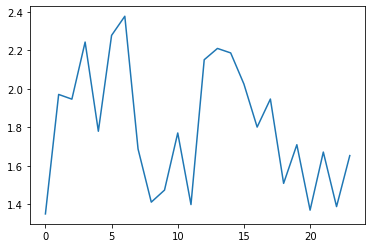

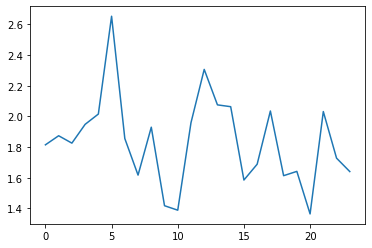

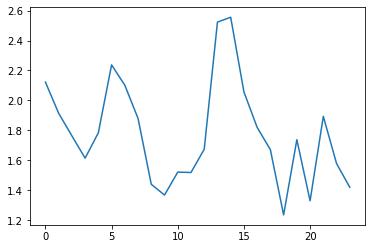

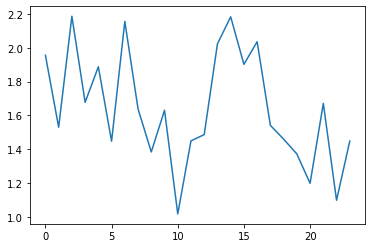

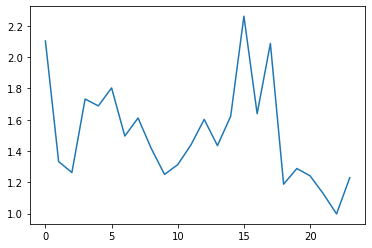

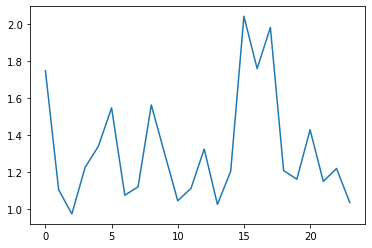

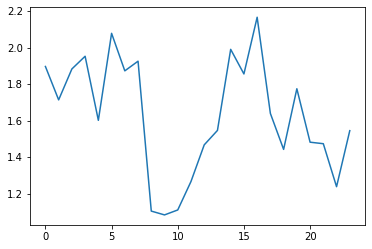

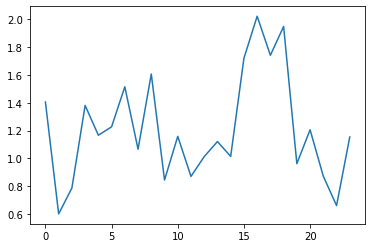

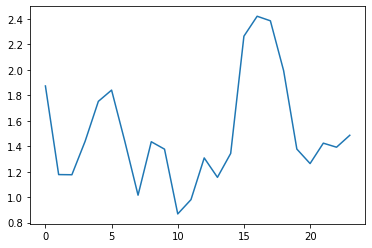

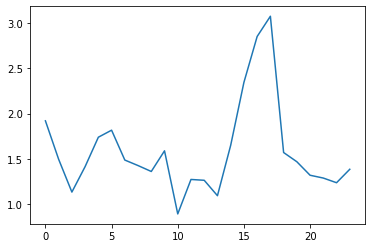

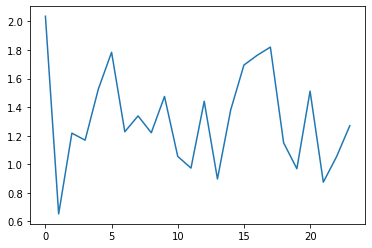

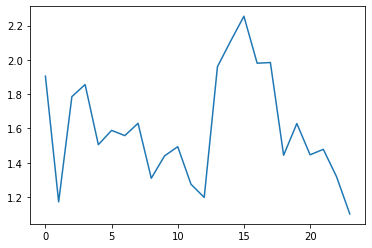

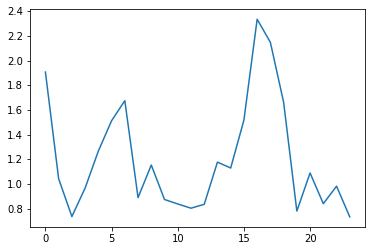

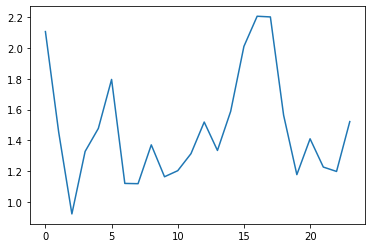

In [11]:
for name in models:
    pt.plot(kzn[name])
    pt.show()

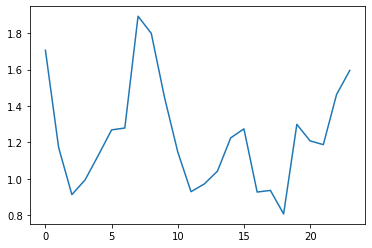

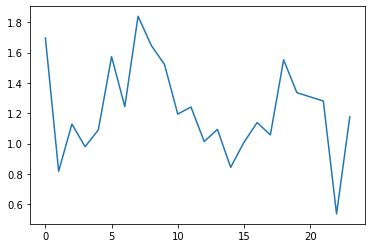

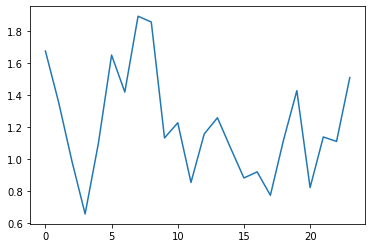

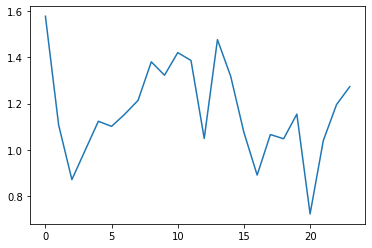

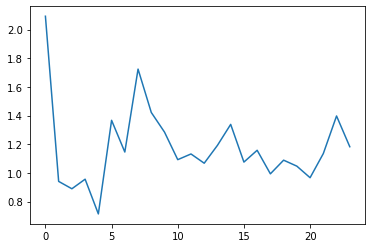

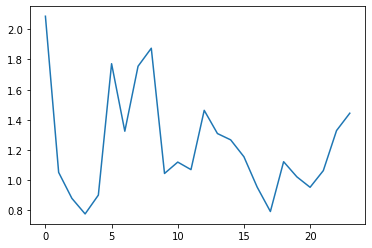

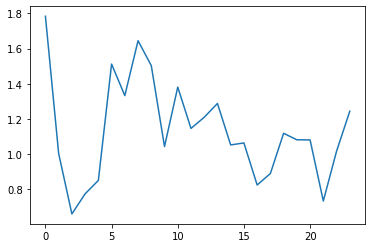

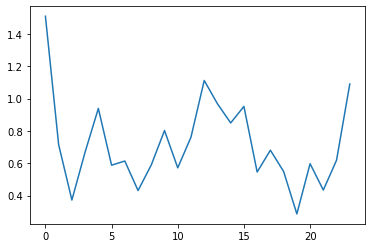

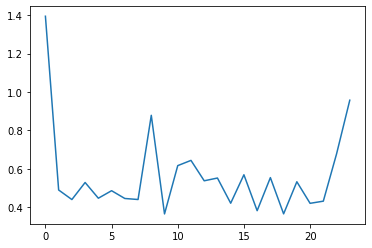

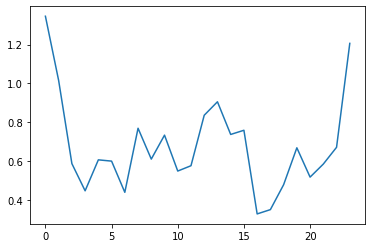

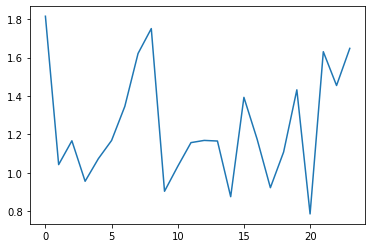

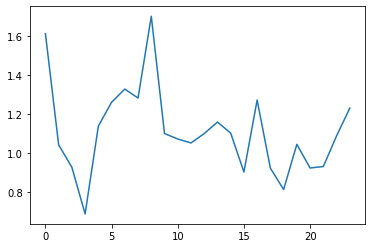

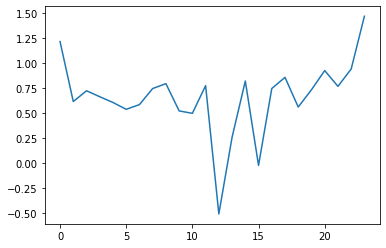

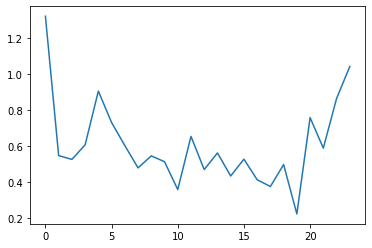

In [12]:
for name in models:
    pt.plot(ksf[name])
    pt.show()